# Adversarial Networks using TensorFlow and the MNIST Dataset

In [1]:
import numpy as np
import sys
import tensorflow as tf
import time

import load_mnist

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

## Fetch and Read In Data

In [2]:
train_im, test_im, train_labels, test_labels = load_mnist.Datasets()

## Some Utility Functions

In [3]:
def weight_variable(shape, init=0.01):
    initial = tf.random_uniform(shape, minval=-init, maxval=init)
    return tf.Variable(initial, name="weights")

def bias_variable(shape, init=0.01):
    initial = tf.constant(init, shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name="conv")

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='SAME', name="max_pool")

def elu(x):
    pos = tf.cast(tf.greater_equal(x, 0), tf.float32)
    return (pos * x) + ((1 - pos) * (tf.exp(x) - 1))

def HiddenLayer(inp, shape, nonlin=elu, init=0.001, scope="RBM"):
    with tf.name_scope(scope) as ns:
        W = weight_variable(shape, init=init)
        b = bias_variable([shape[1]], init=init)
        h = nonlin(tf.matmul(inp, W) + b)
        return W, b, h

## Generative Adversarial Networks
See http://arxiv.org/pdf/1406.2661v1.pdf

In [4]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


#### Generative Network
The generative network maps a vector of uniform random noise inputs to a 28 x 28 1-channel image.

In [5]:
# Input a stack of 32-dimensional noise vectors.
# This spans the underlying object space of 10 digits.
G_x = tf.placeholder(tf.float32, [None, 32])

# Target vector is the probability of being real or a forgery assigned by the discriminator.
G_y_ = tf.placeholder(tf.float32, [None, 1])

# Scale up input from 10 units to 28 * 28 = 784 units
G_W_s1, G_b_s1, G_h_s1 = HiddenLayer(G_x, [32, 128], scope="G_scaleup1")
G_W_s2, G_b_s2, G_h_s2 = HiddenLayer(G_h_s1, [128, 512], scope="G_scaleup2")

# Apply dropout before last scaleup
with tf.name_scope("G_dropout") as scope:
    G_keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    G_h_dropout = tf.nn.dropout(G_h_s2, G_keep_prob)

# Scale up to final size, reshape to image dimensions
G_W_final, G_b_final, G_h_final = HiddenLayer(
    G_h_dropout, [512, 28 * 28], scope="G_scaleup_final")
G_out = tf.nn.sigmoid(tf.reshape(G_h_final, [-1, 28, 28]))
G_out_image = 255 * G_out

#### Discriminative Network

The discriminative network maps a 28 x 28 1-channel image to single float between 0 and 1, representing the probability that the image came from the training data distribution rather than the generative network.

In [6]:
# Input is a stack of 28 x 28 black and white images with activations from 0 to 255.
D_x = G_out_image

# Target vector is a 1 (real) or 0 (forgery) for each input.
D_y_ = tf.placeholder(tf.float32, [None])

# Stack a couple of convolutional layers
nonlin = elu

with tf.name_scope("D_conv1") as scope:
    D_x_scaled = D_x / 255.0
    D_x_image = tf.reshape(D_x_scaled, [-1, 28, 28, 1])
    D_W_conv1 = weight_variable([5, 5, 1, 32])
    D_b_conv1 = bias_variable([32])
    D_h_conv1 = nonlin(conv2d(D_x_image, D_W_conv1) + D_b_conv1)
    D_h_pool1 = max_pool_2x2(D_h_conv1)

with tf.name_scope("D_conv2") as scope:
    D_W_conv2 = weight_variable([5, 5, 32, 64])
    D_b_conv2 = bias_variable([64])
    D_h_conv2 = nonlin(conv2d(D_h_pool1, D_W_conv2) + D_b_conv2)
    D_h_pool2 = max_pool_2x2(D_h_conv2)

# Hidden layer and dropout
with tf.name_scope("D_dense") as scope:
    D_W_dense = weight_variable([7 * 7 * 64, 256])
    D_b_dense = bias_variable([256])
    D_h_dense = nonlin(tf.matmul(tf.reshape(D_h_pool2, [-1, 7 * 7 * 64]), D_W_dense) + D_b_dense)

with tf.name_scope("D_dropout") as scope:
    D_keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    D_h_dropout = tf.nn.dropout(D_h_dense, D_keep_prob)

# Output a single float between 0 and 1
with tf.name_scope("D_output") as scope:
    D_W_out = weight_variable([256, 1])
    D_b_out = bias_variable([1])
    D_y = tf.nn.sigmoid(tf.matmul(D_h_dropout, D_W_out) + D_b_out)

#### Adversarial Training
0. Start with a batch of noise vectors.
1. Feed the noise vectors to the generator to create a batch of forgeries.
2. Mix in with a batch of real training images.
3. Train the discriminator on the mixed bag.
4. Train the generator on the noise vectors from step 0, using the output of the discriminator as the error signal.

In [ ]:
# Generator
# When we evaluate the generator training step, we feed noise into G_x.
# Never evaluate the generator train step when feeding real images into D_x.

G_err = -tf.reduce_mean(tf.log(D_y))
G_train_step = tf.train.AdamOptimizer(0.001).minimize(
    G_err,
    var_list=[
        G_W_s1, G_b_s1,
        G_W_s2, G_b_s2,
        G_W_final, G_b_final])

# Discriminator
# When we evauate the descriminator train step, we should alternate between minibatches
# wherein we provide real images fed into D_x and noise fed into G_x.

D_xent = -tf.reduce_mean(D_y_ * tf.log(D_y)) - tf.reduce_mean((1 - D_y_) * tf.log(1 - D_y))
D_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.greater_equal(D_y, 0.5), tf.float32), D_y_), tf.float32))
D_train_step = tf.train.AdamOptimizer(0.00001).minimize(
    D_xent,
    var_list=[
        D_W_conv1, D_b_conv1,
        D_W_conv2, D_b_conv2,
        D_W_dense, D_b_dense,
        D_W_out, D_b_out])

# Initialize

sess.run(tf.initialize_all_variables())

#### Main loop

..............................
Epoch 0, batch 29 (36.3 seconds since last report)
DISCRIMINATOR: real 100.00% / 0.68747, forged accuracy 0.0% / 0.69824
GENERATOR: error = 0.69


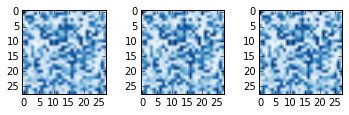

..............................
Epoch 0, batch 59 (13.7 seconds since last report)
DISCRIMINATOR: real 100.00% / 0.68747, forged accuracy 0.0% / 0.69873
GENERATOR: error = 0.69


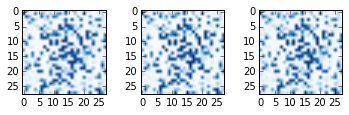

........................

In [ ]:
num_epochs = 1
batch_size = 100
dropout_keep_rate = 0.5
test_every_n_batches = 30

figsize(6, 1.5)

batches_per_epoch = train_im.shape[0] / batch_size
mark = time.time()
train_gen = True
train_disc = True
for ep in xrange(num_epochs):
    for i in xrange(batches_per_epoch):
        sys.stdout.write(".")
        sys.stdout.flush()
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        
        # Train discriminator
        if train_disc:
            # ...on real images
            D_train_step.run(feed_dict={
                D_x: train_im[start_offset:stop_offset],
                D_y_: np.ones(batch_size),
                D_keep_prob: dropout_keep_rate})

            # ...on forgeries
            D_train_step.run(feed_dict={
                G_x: np.random.random((batch_size, 32)),
                G_keep_prob: 1.0,
                D_y_: np.zeros(batch_size),
                D_keep_prob: dropout_keep_rate})

        # Train the generator
        if train_gen:
            G_train_step.run(feed_dict={
                G_x: np.random.random((batch_size, 32)),
                G_keep_prob: dropout_keep_rate,
                D_keep_prob: 1.0})

        if (i + 1) % test_every_n_batches == 0:
            ac_real, xent_real = sess.run(
                [D_accuracy, D_xent], feed_dict={
                    D_x: test_im[:100],
                    D_y_: np.ones(100),
                    D_keep_prob: 1.0})
            ac_forged, xent_forged, im_forged, ger = sess.run(
                [D_accuracy, D_xent, G_out_image, G_err],
                feed_dict={
                    G_x: np.random.random((100, 32)),
                    G_keep_prob: 1.0,
                    D_y_: np.zeros(100),
                    D_keep_prob: 1.0})
            print ("\nEpoch {ep}, batch {ba} ({t:.1f} seconds since last report)"
                   "\nDISCRIMINATOR: real {acr:.2f}% / {xr:.5f}, "
                   "forged accuracy {acf:.1f}% / {xf:.5f}"
                   "\nGENERATOR: error = {ger:.2f}").format(
                ep=ep, ba=i, t=time.time() - mark,
                acr=ac_real * 100, xr=xent_real, acf=ac_forged * 100, xf=xent_forged, ger=ger)
            _, axes = plt.subplots(1, 3)
            for j in xrange(3):
                axes[j].imshow(im_forged[j], cmap=cm.Blues)
            plt.show()
            mark = time.time()
            
            # Handicap!
            score = -(ac_real * np.log2(ac_real + 0.001) + ac_forged * np.log2(ac_forged + 0.001))
            if score < 0.2:
                train_gen, train_disc = True, False
            elif score >= 0.2 and score <= 0.5:
                train_gen, train_disc = True, True
            else:
                train_gen, train_disc = False, True
    